In [575]:
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import arviz
from scipy.stats import beta, binom, gamma, poisson, norm
from scipy.misc import comb
from scipy.special import beta as betaf
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

%matplotlib inline

In [355]:
def plot_beta(betas, lines=[]):
    fig, ax = plt.subplots(1,1)
    theta = np.arange(0, 1, 0.01)
    plt.xlabel(r'$\theta $')
    plt.ylabel('density')
    for b in betas:
        for line in lines:
            ax.axvline(line)
        ax.plot(theta, beta.pdf(theta,b[0],b[1]),
                color=b[2],
                label='beta({},{})'.format(b[0],b[1]))
    ax.legend()
    return ax
    
def plot_gamma(gammas, lines=[]):
    fix, ax = plt.subplots(1,1)
    plt.xlabel(r'$\theta $')
    plt.ylabel('density')
    for g in gammas:
        theta = np.linspace(gamma.ppf(0.001,g[0],scale=1/g[1]), gamma.ppf(0.999,g[0],scale=1/g[1]), 1000)
        ax.plot(theta, gamma.pdf(theta,g[0],scale=1/g[1]),
                color=g[2],
                label='gamma({},{})'.format(g[0],g[1]))
    for line in lines:
            ax.axvline(line)
    ax.legend()
    return ax
    
    
def plot_bar(xs, ys, labels=[]):
    
    fig, ax = plt.subplots()
    plt.bar(xs,ys)

    # zip joins x and y coordinates in pairs
    for x,y in zip(xs,ys):

        label = "{:.2f}".format(y)

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

    ax.set_xticks(xs)
    ax.set_xticklabels(labels)
    plt.show()

## Bayesian Inference Examples

This notebook demonstrates the use of Bayesian inference, by working directly with prior and posterior distributions, as well as the Stan library.

### Example 1: Working with Prior and Posterior Distributions

Two students are given a multiple-choice exam with 40 questions.  Each question has 4 choices.  Student 1 gets 33/40 correct.  Student 2 gets 24/40 correct.  If we think that each student has studied enough that their scores should be better than guessing randomly, how should we model this?

Let $\mathcal{x}$ be a random variable representing a correct answer  
Let $\theta = \mathcal{P}(x)$  
Let $\theta_1 = \mathcal{P}(x=33|\theta)$  
Let $\theta_2 = \mathcal{P}(x=24|\theta)$  

First we need a reasonable prior for theta, given that we suspect that the two students have studied enough to do better than random chance.  Let's look at 3 different beta distributions for our prior.



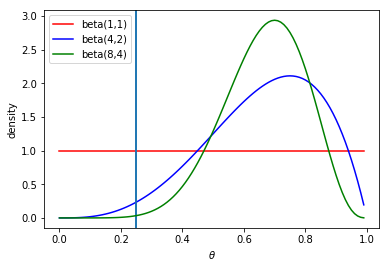

In [135]:
plot_beta([(1,1, 'r'), (4,2, 'b'), (8,4, 'g')], lines=[0.25])

$\mathcal{beta}(8,4)$ appears to have the most mass above our 0.25 cutoff.  We can confirm that with the cumulative density of each beta distribution below.

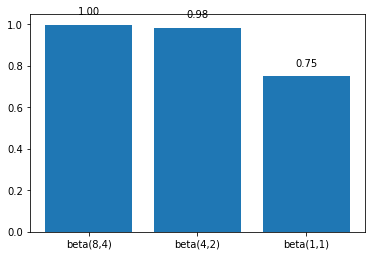

In [116]:
xs = [(8,4), (4,2), (1,1)]
ys = list(map(lambda x: 1-beta.cdf(0.25, x[0], x[1]), xs))
plot_bar(np.arange(len(xs)),ys, labels=['beta(8,4)', 'beta(4,2)', 'beta(1,1)'])

Now let's compute the posterior, which will also be a beta distrbution.  Student 1 got 33 out of 40 questions correct.  Recall that the posterior for a binomial distribution such as this is given as:

$\mathcal{n}$ = 40  
$\alpha$ = 8  
$\beta$ = 4  
$\sum_{i=1}^n x_i$ = 33    
posterior = $\mathcal{beta}$($\alpha$ + $\sum_{i=1}^n x_i$, $\beta$ + $\mathcal{n}$ - $\sum_{i=1}^n x_i$)  
posterior = $\mathcal{beta}$(8+33, 4+40-33)  
posterior = $\mathcal{beta}$(41,11)

MLE = $\mathcal{x}$/$\mathcal{n}$ = 33/40  
posterior mean = $\alpha$ / ($\alpha$ + $\beta$) = 41/(41+11)  
likelihood = $\mathcal{x}\sim\mathcal{binomal}(n,\theta)$  

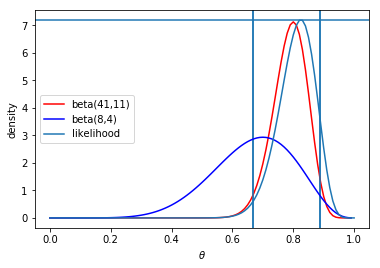

In [300]:
pr_alpha = 8
pr_beta = 4
po_alpha = 41
po_beta = 11
x = 33
n = 40
mle = x/n

lines = [beta.ppf(0.025, po_alpha, po_beta), beta.ppf(0.975, po_alpha, po_beta)]
ax = plot_beta([(po_alpha,po_beta, 'r'), (pr_alpha,pr_beta,'b')], lines=lines)
theta = np.arange(0, 100, 0.01)
ax.plot(theta, binom.pmf(x, n, theta)*44, label='likelihood')
ax.axhline(binom.pmf(x,n,mle)*44)
ax.legend()

Let's do the same for student 2:

$\mathcal{n}$ = 24    
$\alpha$ = 8  
$\beta$ = 4  
$\sum_{i=1}^n x_i$ = 24      
posterior = $\mathcal{beta}$($\alpha$ + $\sum_{i=1}^n x_i$, $\beta$ + $\mathcal{n}$ - $\sum_{i=1}^n x_i$)  
posterior = $\mathcal{beta}$(8+24, 4+40-24)  
posterior = $\mathcal{beta}$(32,20)

MLE = $\mathcal{x}$/$\mathcal{n}$ = 24/40  
posterior mean = $\alpha$ / ($\alpha$ + $\beta$) = 32/(32+20)  
likelihood = $\mathcal{x}\sim\mathcal{binomal}(n,\theta)$  

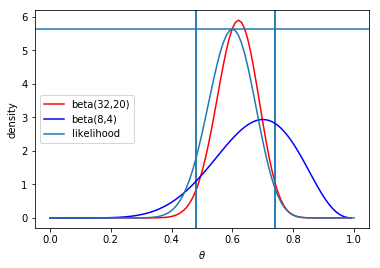

In [299]:
pr_alpha = 8
pr_beta = 4
po_alpha = 32
po_beta = 20
x = 24
n = 40
mle = x/n

lines = [beta.ppf(0.025, po_alpha, po_beta), beta.ppf(0.975, po_alpha, po_beta)]
ax = plot_beta([(po_alpha,po_beta, 'r'), (pr_alpha,pr_beta,'b')], lines=lines)
theta = np.arange(0, 100, 0.01)
ax.plot(theta, binom.pmf(x, n, theta)*44, label='likelihood')
ax.axhline(binom.pmf(x,n,mle)*44)
ax.legend()

Now let's estimate the probability of $\theta_1$ being greater than $\theta_2$.  We do this through simulation, since this is easier than solving analytically.  We're going to draw samples from these distributions:

$\theta_1\sim\mathcal{beta}(41,11)$  
$\theta_1\sim\mathcal{beta}(32,20)$  

and then take the mean of the number of times $\theta_1\gt\theta_2$  

In [140]:
theta1 = beta.rvs(41,11,size=1000)
theta2 = beta.rvs(32,20, size=1000)
np.mean(theta1 > theta2)

0.971

### Example 2: Prior and posterior predictive probabilities

Now let's look at using the Stan language with the Python binding, called PyStan. Let's start with a simple example.  Let's say we have the following:  
$\theta\sim\mathcal{beta}(a,b)$  
$\mathcal{x}\sim\mathcal{binomial}(n, \theta)$  
  
Prior predictive:  
What is $\mathcal{P}(x^* = 1)$ when $\theta\sim\mathcal{beta}(2,2)$?  

Posterior predictive:  
What is $\mathcal{P}(x_{11} = 1)$  when $\theta\sim\mathcal{beta}(2,2)$ and we've observed $\mathcal{k=3}$ successes in $\mathcal{n=10}$ trials? 



In [258]:
beta_binom_model = """
data {
    int<lower=0,upper=1> prior_only;
    int n; //number of trials
    int k; //number of successes
    real<lower=0> a; 
    real<lower=0> b;
}
parameters {
    real<lower=0,upper=1> theta;
}
model {
    theta ~ beta(a, b);  //prior
    if ( prior_only == 0 ) {
        k ~ binomial(n, theta);  //likelihood
    }
}
generated quantities {
    int m = binomial_rng(n, theta);
}
"""
sm = pystan.StanModel(model_code=beta_binom_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_20941722c1a9b2272d404537b9d34c1c NOW.


In [259]:
#prior predictive--no observed data yet so we sample only from the prior
data = {'a':2, 'b':2, 'n':1, 'k':0, 'prior_only': 1}
fit = sm.sampling(data=data, iter=4000, chains=4)
fit

Inference for Stan model: anon_model_20941722c1a9b2272d404537b9d34c1c.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta    0.5  4.1e-3   0.22   0.09   0.32    0.5   0.67    0.9   3078    1.0
m        0.5  6.5e-3    0.5    0.0    0.0    1.0    1.0    1.0   5854    1.0
lp__   -3.34    0.01   0.79  -5.54  -3.54  -3.04  -2.83  -2.77   3502    1.0

Samples were drawn using NUTS at Tue Jun 30 03:54:53 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [279]:
#posterior predictive--we have observed data so we sample from posterior
data = {'a':2, 'b':2, 'k':3, 'n':10, 'prior_only': 0}
fit = sm.sampling(data=data, iter=4000, chains=4)
fit

Inference for Stan model: anon_model_20941722c1a9b2272d404537b9d34c1c.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta   0.36  2.2e-3   0.12   0.14   0.27   0.35   0.44   0.61   3102    1.0
m       3.57    0.03   1.92    0.0    2.0    3.0    5.0    7.0   4856    1.0
lp__   -9.62    0.01    0.7 -11.61  -9.79  -9.36  -9.18  -9.13   3355    1.0

Samples were drawn using NUTS at Tue Jun 30 04:02:12 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

### Example 3 - Poisson Distributions


Likelihood:  
$\mathcal{Y_i}\sim\mathcal{Poisson}(\lambda)$  
$\mathcal{f}(y|\lambda) = \frac{\lambda^{\sum y_i}{e^{-n}}^\lambda}{\prod_{i=1} y_i!}$  
Gamma prior:  
$\lambda \sim \Gamma(\alpha, \beta)$  
$\mathcal{f}(\lambda) = \frac{\beta^\alpha}{\Gamma(\alpha)}{\lambda}^{\alpha-1}{e}^{-\beta\lambda}$  
Prior mean: $\frac{\alpha}{\beta}$  
Prior sdev: $\frac{\sqrt{\alpha}}{\beta}$  
Posterior:  
$\mathcal{f}(\lambda|y) = \mathcal{f}(y|\lambda)\mathcal{f}(\lambda) = {\lambda}^{\sum y_i}{e}^{-n\lambda}{\lambda}^{\alpha - 1}{e}^{-\beta\lambda} = \Gamma(\alpha + \sum y_i, \beta + n)$  
Posterior mean:  
$\frac{\alpha + \sum y_i}{\beta + n}  = \frac{\beta}{\beta+n} * \frac{\alpha}{\beta} + \frac{n}{\beta + n} * \frac{\sum y_i}{n}$  
Vague prior:  
small $\epsilon \gt 0 $  
prior: $\Gamma(\epsilon, \epsilon)$  
posterior: $\Gamma(\epsilon + \sum y_i, \epsilon + n)$  
posterior mean: $\frac{\epsilon + \sum y_i}{\epsilon + n}$  
since epsilon is small, the posterior mean is basically the mean of the observed data  

  
  
Let $\theta$ be the rate of customer service calls per customer per day.  
Let $\mathcal{n}$ be the number of customers.  
Let $\mathcal{t}$ be the number of days.
If $\mathcal{Y}$ is the total number of calls, then we can say  
$\mathcal{Y}\sim\mathcal{Poisson}(nt\theta)$  
  
Prior for $\theta$ is $\theta\sim\mathcal{Gamma}(a,b)$  
Posterior for $\theta$ is $\mathcal{Gamma}(a+y, b+nt)$  
  
  
On average, the customer service center receives 0.01 calls per day, with standard deviation of 0.5:  
  
$\frac{a}{b}$ = 0.01  
$\frac{\sqrt{a}}{b}$ = 0.5  
a = 0.25 $\ b^2$  
$\frac{0.25 b^2}{b}$ = 0.01  
b = 0.04, a = 0.0004  
$\theta\sim\mathcal{Gamma}(0.0004, 0.04)$ for the prior
  
n = 24 customers, t = 5 days, y = 6 customer calls
$\theta\sim\mathcal{Gamma}(6.0004, 120.04)$ for the posterior  





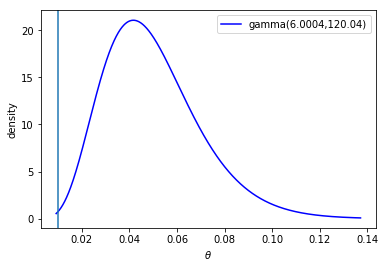

In [358]:
g_pr = (0.0004, 0.04, 'r')
g_po = (6.0004, 120.04, 'b')
y = 6
theta_mean = 0.01
ax = plot_gamma([g_po], lines=[0.01])
#theta = np.arange(0, 100, 0.01)
#ax.plot(theta, poisson.pmf(theta, n, theta)*44, label='likelihood')

In [412]:
temps = np.array([94.6, 95.4, 96.2, 94.9, 95.9])

In [417]:
(temps.mean(), temps.std())

(95.4, 0.5966573556070541)

In [426]:
t1 = 1/0.25
t2 = 1/(0.25/5)
sigma1 = math.pow((t1+t2), -1)

t3 = (100/0.25)
t4 = temps.mean()/(0.25/5)
mean1 = sigma1*(t3+t4)

In [427]:
(mean1, sigma1)

(96.16666666666666, 0.041666666666666664)

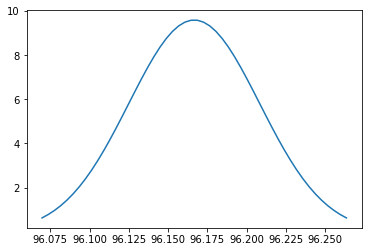

In [436]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(norm.ppf(0.01, mean1, sigma1), norm.ppf(0.99, mean1, sigma1))
ax.plot(x, norm.pdf(x, mean1, sigma1))

In [472]:
norm.ppf(0.975, mean1, np.sqrt(sigma1))

96.56674263969627

In [463]:
z = gamma.rvs(3, scale=1/200, size=1000)
x = 1/z
x.mean()

94.51338347719438

In [461]:
z = gamma.rvs(16.5, scale=1/6022.9, size=5000)
sig2 = 1/z
mu = norm.rvs(loc=609.3, scale=np.sqrt(sig2/27.1), size=5000)
mu

array([607.58216426, 607.99933431, 610.59502332, ..., 611.21797827,
       616.07260835, 610.97959385])

In [462]:
np.percentile(mu, [0.025, 0.975])

array([596.11264586, 600.46845374])

In [464]:
a = 3
b = 200
nA = 30
yA = 622.8
sigmaA = 403.1
w = 0.1

In [465]:
a_prime = a + (nA/2)
a_prime

18.0

In [470]:
t1 = ((nA-1)/2) * sigmaA
t2 = ((w*nA)/(2*(w+nA)))*math.pow((yA-500),2)
b_prime = b + t1 + t2
b_prime

6796.437043189369

In [471]:
m_prime = ((nA*yA) + (w*500))/(w+nA)
m_prime

622.3920265780731

In [482]:
norm_model =  '''
data {
  int<lower=1> n; // number of observations
  vector[n] y; // observations
  real<lower=0> sigma2; //known variance of observations
  real m; //prior mean
  real<lower=0> s2; //variance of theta
}
parameters {
  real theta; // unknown mean
}
model {
  target += normal_lpdf(theta | m, sqrt(s2));
  target += normal_lpdf(y | theta, sqrt(sigma2));
}
'''
sm = pystan.StanModel(model_code=norm_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_39020475a9b9549bf60537489c5c05ad NOW.


In [483]:
data = {
    'n': 5,
    'y': [94.6, 95.4, 96.2, 94.9, 95.9],
    'm': 100,
    'sigma2': 0.25,
    's2': 0.25
}
fit=sm.sampling(data = data, iter=4000, chains=4)

In [484]:
fit

Inference for Stan model: anon_model_39020475a9b9549bf60537489c5c05ad.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta  96.16  3.8e-3    0.2  95.77  96.02  96.17   96.3  96.56   2857    1.0
lp__  -40.68    0.01   0.68 -42.68 -40.83 -40.41 -40.23 -40.18   3573    1.0

Samples were drawn using NUTS at Sun Jul 26 20:47:49 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [488]:
norm_model_1 =  '''
data {
  int<lower=1> n; // number of observations
  vector[n] y;
  real m; //prior mean
  int alpha;  //used in inverse gamma for marginal prior of sigma2
  int beta; //used in invese gamma for marginal prior of sigma2
  real w; //effective sample size of prior mean
}
parameters {
  real mu; // unknown mean
  real<lower=0> sigma2; //unknown variance
}
model {
  target += inv_gamma_lpdf(sigma2 | alpha, beta);
  target += normal_lpdf(mu | m, sqrt(sigma2/w));
  target += normal_lpdf(y | mu, sqrt(sigma2));
}
'''
sm = pystan.StanModel(model_code=norm_model_1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_aaa8f7905eb58f4b80f36aa12defc473 NOW.


In [499]:
dataA = {
    'n': 30,
    'm': 500,
    'alpha': 3,
    'beta': 200,
    'w': 0.1,
    'y': norm.rvs(622.8, np.sqrt(403.1), size=30)
}
dataB = {
    'n': 27,
    'm': 500,
    'alpha': 3,
    'beta': 200,
    'w': 0.1,
    'y': norm.rvs(609.7, np.sqrt(401.8), size=27)
}

In [518]:
fitA=sm.sampling(data = dataA, iter=4000, chains=4)
fitB=sm.sampling(data = dataB, iter=4000, chains=4)

In [519]:
np.sum(fitA['mu'] > fitB['mu'])/fitA['mu'].size

0.998375

In [537]:
df = pd.read_csv('http://www.randomservices.org/random/data/Challenger2.txt', delimiter='\t')
df

,T,I
0,53,11
1,57,4
2,58,4
3,63,2
4,66,0
5,67,0
6,67,0
7,67,0
8,68,0
9,69,0


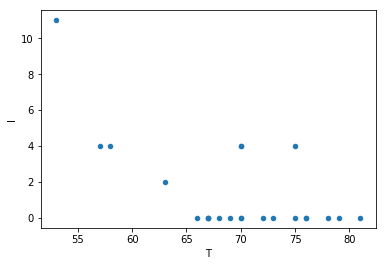

In [571]:
df.plot.scatter(x='T', y='I')

In [547]:
X = np.array(df['T']).reshape(-1,1)
y = np.array(df['I'])
reg = LinearRegression().fit(X,y)

In [553]:
(reg.coef_, reg.intercept_)

(array([-0.24337302]), 18.365079365079357)

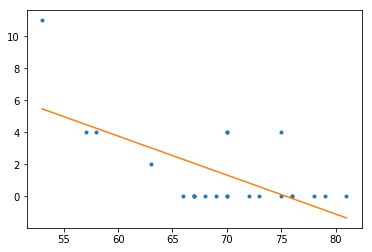

In [573]:
fig, ax = plt.subplots(1, 1)
ax.plot(X, y, '.')
ax.plot(X, (reg.intercept_ + (reg.coef_*X)))

In [576]:
lm = smf.ols(formula='I~T', data=df).fit()
lm.params

Intercept    18.365079
T            -0.243373
dtype: float64

In [577]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      I   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     14.69
Date:                Sun, 02 Aug 2020   Prob (F-statistic):           0.000968
Time:                        18:45:25   Log-Likelihood:                -48.672
No. Observations:                  23   AIC:                             101.3
Df Residuals:                      21   BIC:                             103.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.3651      4.439      4.138      0.000       9.135      27.596
T             -0.2434      0.063     -3.833      0.001      -0.375      -0.111
==============================================================================
Omnibus:                        7.558   Durbin-Watson:                   1.466
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                5.542
Skew:                           1.152   Prob(JB):                       0.0626
Kurtosis:                       3.687   Cond. No.                         708.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [578]:
lm.conf_int()

,0,1
Intercept,9.134531,27.595627
T,-0.375414,-0.111332


In [581]:
lm.predict({'T': [31]})

0    10.820516
dtype: float64

In [590]:
upper_lm = smf.quantreg('I~T', data=df).fit(q=0.975)
upper_lm.summary()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/regression/quantile_regression.py:237: RuntimeWarning: invalid value encountered in less_equal
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: Runtim

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                      I   Pseudo R-squared:               0.6540
Model:                       QuantReg   Bandwidth:                         nan
Method:                 Least Squares   Sparsity:                          nan
Date:                Sun, 02 Aug 2020   No. Observations:                   23
Time:                        19:04:51   Df Residuals:                       21
                                        Df Model:                            1
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     27.8636        nan        nan        nan         nan         nan
T             -0.3182        nan        nan        nan         nan         nan
==============================================================================
"""

In [589]:
upper_lm.predict({'T':[31]})

0    6.923075
dtype: float64

In [597]:
df_height = pd.read_csv('http://www.randomservices.org/random/data/Galton.txt', 
                        delimiter='\t')

In [601]:
lm_height = smf.ols('Height~Father+Mother+Gender+Kids', data=df_height).fit()

In [602]:
lm_height.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Height   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     398.1
Date:                Sun, 02 Aug 2020   Prob (F-statistic):          9.09e-197
Time:                        19:11:06   Log-Likelihood:                -1960.1
No. Observations:                 898   AIC:                             3930.
Df Residuals:                     893   BIC:                             3954.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      16.1877      2.794      5.794      0.000      10.704      21.671
Gender[T.M]     5.2099      0.144     36.125      0.000       4.927       5.493
Father          0.3983      0.030     13.472      0.000       0.340       0.456
Mother          0.3210      0.031     10.269      0.000       0.260       0.382
Kids           -0.0438      0.027     -1.612      0.107      -0.097       0.010
==============================================================================
Omnibus:                       12.177   Durbin-Watson:                   1.566
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               16.265
Skew:                          -0.149   Prob(JB):                     0.000294
Kurtosis:                       3.588   Cond. No.                     3.68e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [604]:
lm_height = smf.ols('Height~Father+Mother+Gender', data=df_height).fit()
lm_height.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Height   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     529.0
Date:                Sun, 02 Aug 2020   Prob (F-statistic):          1.33e-197
Time:                        19:12:39   Log-Likelihood:                -1961.4
No. Observations:                 898   AIC:                             3931.
Df Residuals:                     894   BIC:                             3950.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      15.3448      2.747      5.586      0.000       9.954      20.736
Gender[T.M]     5.2260      0.144     36.289      0.000       4.943       5.509
Father          0.4060      0.029     13.900      0.000       0.349       0.463
Mother          0.3215      0.031     10.277      0.000       0.260       0.383
==============================================================================
Omnibus:                       11.936   Durbin-Watson:                   1.560
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               15.952
Skew:                          -0.145   Prob(JB):                     0.000344
Kurtosis:                       3.585   Cond. No.                     3.61e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.61e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [615]:
df_golf = pd.read_csv('http://www.stat.ufl.edu/~winner/data/pgalpga2008.dat',
                      sep = '\s+',
                      names=['distance', 'accuracy', 'gender'],
                      header=None)
df_golf

,distance,accuracy,gender
0,243.2,67.0,1
1,254.5,70.1,1
2,253.1,59.3,1
3,228.1,70.4,1
4,240.8,69.5,1
5,244.0,69.0,1
6,257.9,66.3,1
7,255.8,68.3,1
8,249.9,63.5,1
9,251.3,70.3,1


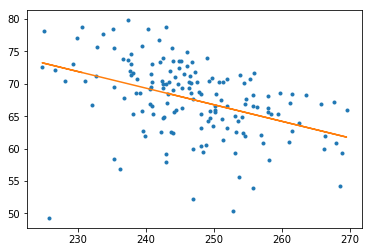

In [622]:
X = np.array(df_golf[df_golf['gender'] == 1]['distance']).reshape(-1,1)
y = np.array(df_golf[df_golf['gender'] == 1]['accuracy'])
reg_f = LinearRegression().fit(X,y)

fig, ax = plt.subplots(1, 1)
ax.plot(X, y, '.')
ax.plot(X, (reg_f.intercept_ + (reg_f.coef_*X)))

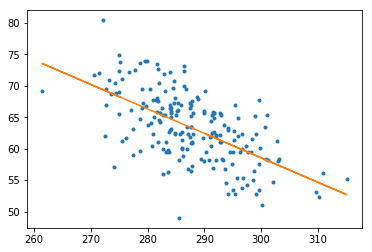

In [623]:
X = np.array(df_golf[df_golf['gender'] == 2]['distance']).reshape(-1,1)
y = np.array(df_golf[df_golf['gender'] == 2]['accuracy'])
reg_m = LinearRegression().fit(X,y)

fig, ax = plt.subplots(1, 1)
ax.plot(X, y, '.')
ax.plot(X, (reg_m.intercept_ + (reg_m.coef_*X)))

In [624]:
reg_f.coef_

array([-0.2564907])